In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from glob import glob
import seaborn as sns
sns.set()

import sklearn
import skimage
from skimage.transform import resize

import random
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [2]:
X_train = np.load("xtrain.npy")
y_train = np.load("ytrain.npy")
X_test = np.load("xtest.npy")
y_test = np.load("ytest.npy")

In [3]:
from keras.models import model_from_json
json_file = open('future_extractor.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
future_extractor = model_from_json(loaded_model_json)
# load weights into new model
future_extractor.load_weights("future_extractor.h5")
print("Loaded model from disk")

Loaded model from disk


In [4]:
from xgboost import XGBClassifier

In [5]:
X_for_XB = future_extractor.predict(X_train)

In [6]:
model = XGBClassifier()
model.fit(X_for_XB,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [7]:
X_test_feature = future_extractor.predict(X_test)

In [8]:
prediction_XB = model.predict(X_test_feature)

In [9]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_XB))

Accuracy =  0.9852941176470589


In [10]:
precision = sklearn.metrics.precision_score(y_test,prediction_XB, pos_label=0)
precision

1.0

In [11]:
recall = sklearn.metrics.recall_score(y_test, prediction_XB, pos_label=0)
recall

0.9782608695652174

In [12]:
f1_score = 2 * ((precision * recall) / (precision + recall))
f1_score

0.989010989010989

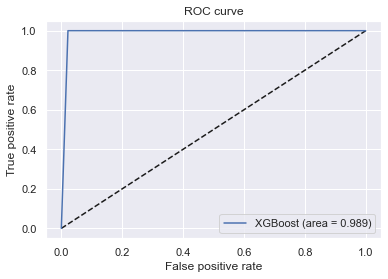

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_rf = prediction_XB
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("xgboostroc.jpg")
plt.show()

<AxesSubplot:>

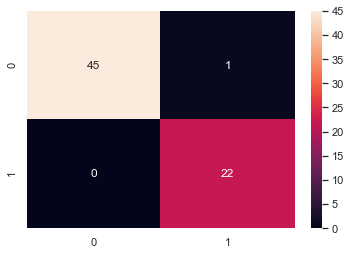

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_XB)
#print(cm)
sns.heatmap(cm, annot=True)